# **Non IID data in Federated Learning contexts**

# 1. Where we left off

Last time we were able to implement Federated Averaging on IID data; As we'll see in this new experiment, this is more often than not problematic at best.

Let's start by loading the previous accuracy histories; last time we saw that the federated averaging one and the centralized training one produced really similar accuracy, while here we'll see more in depth the biggest reason of why this happened.

In [1]:
import gdown
import numpy as np
import os

# This is based on my drive, should work:
file_ids = ["1QmzTIrNFpxZV9MwIgEJTQ1XMxc2BI2Bt", "1JygZg8inFoJ1RE6LA19uggOx-qODHvXu"]
filenames = ["centralized_val_acc.npy", "federated_iid_acc.npy"]

for file_id, filename in zip(file_ids, filenames):
    url = f"https://drive.google.com/uc?id={file_id}"
    
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        gdown.download(url, filename, quiet=False)
    else:
        print(f"{filename} already exists.")

centralized_val_acc = np.load("centralized_val_acc.npy")
federated_iid_acc = np.load("federated_iid_acc.npy")

print("Loaded arrays:")
print("Centralized len:", len(centralized_val_acc))
print("Fed IID len:", len(federated_iid_acc))

Downloading...
From: https://drive.google.com/uc?id=1QmzTIrNFpxZV9MwIgEJTQ1XMxc2BI2Bt
To: /kaggle/working/centralized_val_acc.npy
100%|██████████| 328/328 [00:00<00:00, 1.23MB/s]


Downloading...
From: https://drive.google.com/uc?id=1JygZg8inFoJ1RE6LA19uggOx-qODHvXu
To: /kaggle/working/federated_iid_acc.npy
100%|██████████| 328/328 [00:00<00:00, 1.15MB/s]

Loaded arrays:
Centralized len: 25
Fed IID len: 25


Let's re-plot everything like last time:

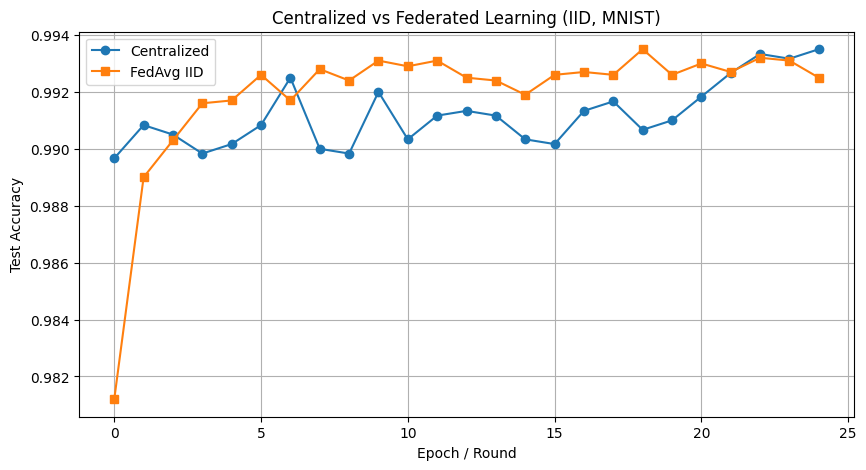

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Centralized accuracy per epoch
plt.plot(centralized_val_acc, marker='o', label='Centralized')

# Federated IID accuracy per round
plt.plot(federated_iid_acc, marker='s', label='FedAvg IID')

plt.title("Centralized vs Federated Learning (IID, MNIST)")
plt.xlabel("Epoch / Round")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)

# Save figure if you want
plt.savefig("centralized_vs_federated_iid.png", dpi=300, bbox_inches='tight')

plt.show()

# 2. Non IID data

A big assumptions we made during the last experiment is the fact that the clients presented an IID (Independent and Identically Distributed), which in practice (meaning for our experiment with the MNIST dataset) meant that every client presented almost the same distribution of features and labels.
> In statistics **IID data** is a statistical concept where each data point (or random variable) is both independent of the others and comes from the same probability distribution; for *indipendent* we mean that the outcome of one observation does not influence the outcome of next observations (an example could be a coin flip, which does not change the probability of the next flip to be head or tails), while for *identically distributed* we mean that all the observations are drawn from the same probability distribution (for example in a series of dice rolls each roll has the same probability of any number 1 to 6)

Let's now imagine this scenario:

We have some hospitals (5 for example) that want to collaborate to make a diagnosis tool for disease Y; for this reason, they'll need to update their global model which is managed by a decentralized server, BUT without (for obvious reasons) sharing the patients' health records.

This is also called the **cross-silo setup**, a scenario where a small number of large, stable organizations (the "silos") collaboratively train a shared machine learning model without directly sharing their raw data.

Let's go back to the problem. In such a real life application, the data of the silos is very (very) unlikely to be IID; most of the time in such applications we'll have to do with **non IID data**.

In our example, the non IID data could be due to many factors, such as but not limited to:
* **Geographic/Demographic Skew**: A hospital in an urban area will have a different patient population than a hospital in a rural area (which will probably have an older population), which means that the hospitals will likely have different diseases prevalence in their datasets
* **Specialization Skew**: for example an hospital could be specialized in oncology, or another in neurology; then they'll likely have a disproportionate amount of data on that specialization, while a normal hospital has a more mixed distribution
* **Imaging Equipment Variation**: even small differences, such as different equipments, or different calibrations for CT or MRI scanners, means a likely different data distribution, as the data generation process is not identical

The procedure, as we'll see now, is basically the same as the classical FedAvg process, with only a difference that we'll address shortly (this also means I'm not going to explain in detail every step as I did previously).

# 3. Like last time...

First we import MNIST and redefine the function to create the CNN models we'll use:

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# normalizing

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

# channel dimensions for our network

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_cnn()
global_model = model
model.summary()

2025-12-27 20:12:45.746799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766866366.196066      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766866366.326428      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1766866390.013120      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766866390.013783      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Non IID partitioning

This is where I'm going to put in practice the non-IID data concept.

In particular we'll use what is widely considered the most common approach for non-IID data, which also combines very well with what we said earlier about the hospitals; this approach is called **Dirichlet-based Non-IID partitioning** and it is based on the Dirichlet distribution, which focuses on controlling how skewed the label distribution is among clients, thanks to a variable $alpha$; particulary, we recognize the following situations:
* High α (e.g., α = 10) → Nearly IID, Every client has all labels in similar proportions.

* Medium α (e.g., α = 1) → Mild non-IID, Clients have all labels but in different amounts.

* Low α (e.g., α = 0.1) → Strong non-IID, Clients mostly have only a few labels.

In our experiment I'll use a list which contains respectively a mild alpha (0.5), a lower one (0.15), and the *extreme non IID* (also called **Label Sharding**, 0.01), which in practice means that each client has ONLY the assigned two classes (like 0 and 1, or 2 and 3)

In [4]:
def create_dirichlet_noniid(x, y, num_clients=5, alpha=0.5):
    num_classes = 10
    data_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    client_indices = [[] for _ in range(num_clients)]
    
    # For each class, distribute samples using Dirichlet distribution
    for c in range(num_classes):
        idx = data_indices[c]
        np.random.shuffle(idx)

        # sample proportions for this class
        proportions = np.random.dirichlet([alpha] * num_clients)

        # split class samples among clients
        splits = (proportions * len(idx)).astype(int)

        # fix rounding
        while splits.sum() < len(idx):
            splits[np.argmax(proportions)] += 1

        start = 0
        for client_id in range(num_clients):
            end = start + splits[client_id]
            client_indices[client_id].extend(idx[start:end])
            start = end
    
    # build client datasets
    clients = []
    for cid in range(num_clients):
        c_idx = np.array(client_indices[cid])
        clients.append((x[c_idx], y[c_idx]))

    return clients

For each $alpha$ we produce the respective non IID split by using a dictionary:

In [5]:
# Create 3 non-IID splits using Dirichlet distribution
alphas = [0.5, 0.15, 0.01]  # mild, medium, extreme non-IID
noniid_splits = {}

for a in alphas:
    print(f"\nCreated NON-IID split for alpha = {a}")
    noniid_splits[a] = create_dirichlet_noniid(
        x_train, 
        y_train, 
        num_clients = 5, 
        alpha = a
    )


Created NON-IID split for alpha = 0.5

Created NON-IID split for alpha = 0.15

Created NON-IID split for alpha = 0.01


Again, this next part is basically the same as the previous experiment; first of all we re-implement the local_update function, which was needed to train the clients locally before sending the updates straight to the global model

In [6]:
import json

def local_update(global_model, cx, cy, local_epochs=2, batch_size=32,
                 save_attack_data=False, attack_id="client0"):

    # creates a new model and sets global weights
    local_model = create_cnn()
    weights_before = global_model.get_weights()
    local_model.set_weights(weights_before)

    # trains locally
    reduce_lr = ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=1,
        min_lr=1e-6,
        verbose=0
    )

    early_stop = EarlyStopping(
        monitor='loss',
        patience=2,
        restore_best_weights=True,
        verbose=0
    )

    local_model.fit(
        cx, cy,
        epochs=local_epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[reduce_lr, early_stop]
    )

    # weights post-training
    weights_after = local_model.get_weights()
    
    # Return updated weights for FedAvg
    return weights_after

Now that all the updates are theorically ready we can apply Federated Averaging:

In [7]:
def fedavg(weights_list, data_sizes):

    total_size = np.sum(data_sizes)
    
    # initialize aggregated weights with zeros
    aggregated = [np.zeros_like(w) for w in weights_list[0]]
    
    # weighted sum from the dataset size
    for weights, size in zip(weights_list, data_sizes):
        for i in range(len(weights)):
            aggregated[i] += (size / total_size) * weights[i]
    
    return aggregated

We finally obtain the results, making sure to implement a loop to test everything for each $alpha$

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

num_rounds = 10
num_clients = 5
local_epochs = 2

results = {}   # to store accuracy history for each alpha

for alpha in alphas:
    print(f"Training with alpha = {alpha}")

    # chooses the right split
    clients_to_use = noniid_splits[alpha]

    # fresh global model for each alpha
    global_model = create_cnn()

    acc_history = []

    for rnd in range(1, num_rounds + 1):
        print(f"\nFederated Round {rnd} (alpha = {alpha})")

        client_weights = []
        client_sizes = []

        # send global model to each client
        for cid in range(num_clients):
            x_c, y_c = clients_to_use[cid]
            client_sizes.append(len(x_c))

            updated_w = local_update(
                global_model,
                x_c, y_c,
                local_epochs=local_epochs,
                batch_size=32,
                save_attack_data=(alpha == 0.15 and rnd == 1 and cid == 0),
                attack_id="mnist_noniid_alpha015"
            )

            client_weights.append(updated_w)

        # FedAvg
        new_global_weights = fedavg(client_weights, client_sizes)
        global_model.set_weights(new_global_weights)

        # evaluation
        loss, acc = global_model.evaluate(x_test, y_test, verbose=0)
        acc_history.append(acc)

        print(f"Global Test Accuracy: {acc:.4f}")

    # stores history for plotting
    results[alpha] = acc_history

Training with alpha = 0.5

Federated Round 1 (alpha = 0.5)


I0000 00:00:1766866393.992321     115 service.cc:148] XLA service 0x7c8ff0006950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766866393.993440     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766866393.993457     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766866394.308935     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1766866397.269209     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Global Test Accuracy: 0.9218

Federated Round 2 (alpha = 0.5)
Global Test Accuracy: 0.9823

Federated Round 3 (alpha = 0.5)
Global Test Accuracy: 0.9857

Federated Round 4 (alpha = 0.5)
Global Test Accuracy: 0.9887

Federated Round 5 (alpha = 0.5)
Global Test Accuracy: 0.9891

Federated Round 6 (alpha = 0.5)
Global Test Accuracy: 0.9887

Federated Round 7 (alpha = 0.5)
Global Test Accuracy: 0.9893

Federated Round 8 (alpha = 0.5)
Global Test Accuracy: 0.9903

Federated Round 9 (alpha = 0.5)
Global Test Accuracy: 0.9903

Federated Round 10 (alpha = 0.5)
Global Test Accuracy: 0.9898
Training with alpha = 0.15

Federated Round 1 (alpha = 0.15)
Global Test Accuracy: 0.8317

Federated Round 2 (alpha = 0.15)
Global Test Accuracy: 0.9541

Federated Round 3 (alpha = 0.15)
Global Test Accuracy: 0.9542

Federated Round 4 (alpha = 0.15)
Global Test Accuracy: 0.9619

Federated Round 5 (alpha = 0.15)
Global Test Accuracy: 0.9785

Federated Round 6 (alpha = 0.15)
Global Test Accuracy: 0.9799

Federa

Let's now plot the history of accuracy for each alpha:

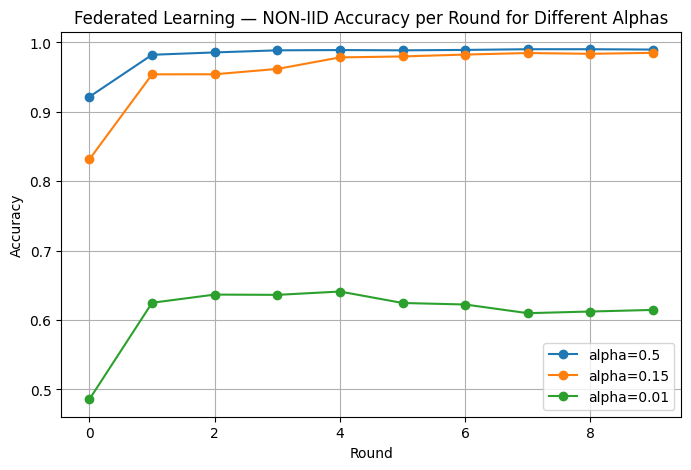

In [9]:
plt.figure(figsize=(8,5))
for alpha in alphas:
    plt.plot(results[alpha], marker='o', label=f'alpha={alpha}')

plt.title("Federated Learning — NON-IID Accuracy per Round for Different Alphas")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 5. Results and observations

We can now confront everything we obtained against the centralized training and Federated Learning with IID data

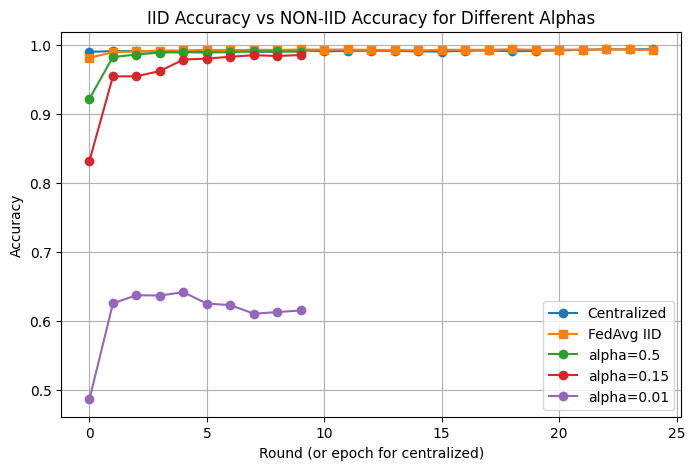

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(8,5))

# Centralized accuracy per epoch
plt.plot(centralized_val_acc, marker='o', label='Centralized')

# Federated IID accuracy per round
plt.plot(federated_iid_acc, marker='s', label='FedAvg IID')

for alpha in alphas:
    plt.plot(results[alpha], marker='o', label=f'alpha={alpha}')

plt.title("IID Accuracy vs NON-IID Accuracy for Different Alphas")
plt.xlabel("Round (or epoch for centralized)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.savefig("federated_iid_vs_federated_noniid.png", dpi=300, bbox_inches='tight')

First thing we obviously notice is that Centralized training (and Federated Training with IID) and alpha 0.5 are pretty similar; as I said before, at 0.5 the distribution is not that far off from the original IID one, just a bit skewed on some features rather than others.

For 0.15 and 0.01 instead we see a clear decrease in performance (for 0.01 usually, as I tried this many times, the results are even lower, stagnating sometimes at around 55/60%). This is because this time the distribution is very much more diverse, a phenomenon which is also called **heterogeneity**.

Anyhow, as you clearly see all the federated curves have two main things in common:
1. As i said previously, FedAvg undirectly causes less noise fluctuations in the learning (which can clearly be seen in detail in the image at the start of the notebook)
2. Secondly we clearly see the effect of the first local updates and then the global aggregations. In particular, all the FL curves start from a lower accuracy level, and quickly rise as updates gather, until reaching its limit plateau (also worth noting how the slope of this quick rise in accuracy seems proportional to the alpha we used, with lower alphas showing a more pronounced and fast slope)

While for this dataset the difference doesn't seem that great (the model can still be used with a pretty good degree of accuracy till about an alpha of around 0.25), in real life contexts (like medical, or more complex image recognition) the datasets will likely be way harder then the classic MNIST one we use for its performance, meaning that the accuracy drop will be indeed really heavy.

This demonstrates how much non IID influences the precision and performance of Federating Learning systems.

# 6. What's next?

Next time hopefully I'll introduce some possible privacy attack on FL setups